# Figure 4A: Restrict gene list by KEGG pathways

In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *
from kegg_utils import *

# Scrape KEGG data

In [ ]:
DIR_kegg="/home/zeqianli/project/zeqian/Carbon/data/kegg"

### Pathways

In [ ]:
pathways=pd.read_csv(os.path.join(DIR_kegg,"pathway_list.txt"),header=None).values.flatten()

In [ ]:
# kos 
kos=Kegg.download_csv(["link/ko",*pathways],labels=['pathway','ko'])
kos['pathway']=kos['pathway'].str.replace("path:","")
kos['ko']=kos['ko'].str.replace("ko:","")

for _, pathway, ko in kos.itertuples():
    if not os.path.exists(os.path.join(DIR_kegg,"kos",ko)):
        with open(os.path.join(DIR_kegg,"kos",ko),'w') as f:
            pass # create an empty file
    
    if not os.path.exists(os.path.join(DIR_kegg,"pathways",pathway)):
        os.makedirs(os.path.join(DIR_kegg,"pathways",pathway))
    with open(os.path.join(DIR_kegg,"pathways",pathway,'kos.txt'),'a') as f:
        f.write(ko)
        f.write('\n')

In [ ]:
# modules
#modules=Kegg.download_csv(["link/module",*pathways],labels=['pathway','module'])
modules=pd.read_csv('http://rest.kegg.jp/list/module',sep='\t+',header=None,names=['module','module_name'])
# modules['pathway']=modules['pathway'].str.replace("path:","")
modules['module']=modules['module'].str.replace("md:","")

for _, pathway, module in modules.itertuples():
    if not os.path.exists(os.path.join(DIR_kegg,"modules",module)):
        os.makedirs(os.path.join(DIR_kegg,"modules",module))
    
    if not os.path.exists(os.path.join(DIR_kegg,"pathways",pathway)):
        os.makedirs(os.path.join(DIR_kegg,"pathways",pathway))
    with open(os.path.join(DIR_kegg,"pathways",pathway,'modules.txt'),'a') as f:
        f.write(module)
        f.write('\n')

In [ ]:
# modules
#modules=Kegg.download_csv(["link/module",*pathways],labels=['pathway','module'])
modules=pd.read_csv('http://rest.kegg.jp/list/module',sep='\t+',header=None,names=['module','module_name'])
# modules['pathway']=modules['pathway'].str.replace("path:","")
modules['module']=modules['module'].str.replace("md:","")

for _, module,_ in modules.itertuples():
    if not os.path.exists(os.path.join(DIR_kegg,"modules",module)):
        os.makedirs(os.path.join(DIR_kegg,"modules",module))
    
    # if not os.path.exists(os.path.join(DIR_kegg,"pathways",pathway)):
    #     os.makedirs(os.path.join(DIR_kegg,"pathways",pathway))
    # with open(os.path.join(DIR_kegg,"pathways",pathway,'modules.txt'),'a') as f:
    #     f.write(module)
    #     f.write('\n')

In [ ]:
# reactions
reactions=Kegg.download_csv(["link/reaction",*pathways],labels=['pathway','reaction'])
reactions['pathway']=reactions['pathway'].str.replace("path:","")
reactions['reaction']=reactions['reaction'].str.replace("rn:","")

for _, pathway, reaction in reactions.itertuples():
    if not os.path.exists(os.path.join(DIR_kegg,"reactions",reaction)):
        os.makedirs(os.path.join(DIR_kegg,"reactions",reaction))
    
    if not os.path.exists(os.path.join(DIR_kegg,"pathways",pathway)):
        os.makedirs(os.path.join(DIR_kegg,"pathways",pathway))
    with open(os.path.join(DIR_kegg,"pathways",pathway,'reactions.txt'),'a') as f:
        f.write(reaction)
        f.write('\n')

In [ ]:
# compounds
compounds=Kegg.download_csv(["link/compound",*pathways],labels=['pathway','compound'])
compounds['pathway']=compounds['pathway'].str.replace("path:","")
compounds['compound']=compounds['compound'].str.replace("cpd:","")

for _, pathway, compound in compounds.itertuples():
    if not os.path.exists(os.path.join(DIR_kegg,"compounds",compound)):
        with open(os.path.join(DIR_kegg,"compounds",compound),'w') as f:
            pass # create an empty file
    
    if not os.path.exists(os.path.join(DIR_kegg,"pathways",pathway)):
        os.makedirs(os.path.join(DIR_kegg,"pathways",pathway))
    with open(os.path.join(DIR_kegg,"pathways",pathway,'compounds.txt'),'a') as f:
        f.write(compound)
        f.write('\n')

### Modules

In [ ]:
modules=os.listdir(os.path.join(DIR_kegg,"modules"))

compounds=Kegg.download_csv(["link/compound",*modules],labels=['module','compound'])
compounds['module']=compounds['module'].str.replace("md:","")
compounds['compound']=compounds['compound'].str.replace("cpd:","")

for _, module, compound in compounds.itertuples():
    with open(os.path.join(DIR_kegg,"modules",module,'compounds.txt'),'a') as f:
        f.write(compound)
        f.write('\n')

kos=Kegg.download_csv(["link/ko",*modules],labels=['module','ko'])
kos['module']=kos['module'].str.replace("md:","")
kos['ko']=kos['ko'].str.replace("ko:","")

for _, module, ko in kos.itertuples():
    with open(os.path.join(DIR_kegg,"modules",module,'kos.txt'),'a') as f:
        f.write(ko)
        f.write('\n')

reactions=Kegg.download_csv(["link/reaction",*modules],labels=['module','reaction'])
reactions['module']=reactions['module'].str.replace("md:","")
reactions['reaction']=reactions['reaction'].str.replace("rn:","")

for _, module, reaction in reactions.itertuples():
    with open(os.path.join(DIR_kegg,"modules",module,'reactions.txt'),'a') as f:
        f.write(reaction)
        f.write('\n')

### Reactions

In [ ]:
reactions=os.listdir(os.path.join(DIR_kegg,"reactions"))

compounds=Kegg.download_csv(["link/compound",*reactions],labels=['reaction','compound'])
compounds['reaction']=compounds['reaction'].str.replace("rn:","")
compounds['compound']=compounds['compound'].str.replace("cpd:","")

for _, reaction, compound in compounds.itertuples():
    with open(os.path.join(DIR_kegg,"reactions",reaction,'compounds.txt'),'a') as f:
        f.write(compound)
        f.write('\n')

kos=Kegg.download_csv(["link/ko",*reactions],labels=['reaction','ko'])
kos['reaction']=kos['reaction'].str.replace("rn:","")
kos['ko']=kos['ko'].str.replace("ko:","")

for _, reaction, ko in kos.itertuples():
    with open(os.path.join(DIR_kegg,"reactions",reaction,'kos.txt'),'a') as f:
        f.write(ko)
        f.write('\n')



### Full text

In [ ]:
import requests

# pathways

pathways=os.listdir(os.path.join(DIR_kegg,"pathways"))
for pathway in tqdm(pathways,desc="Retriving pathway information"):
    try:
        res=requests.get(f"http://rest.kegg.jp/get/{pathway}")
        if not bool(res):
            raise ValueError
        with open(os.path.join(DIR_kegg,"pathways",pathway,pathway),'w') as f:
            f.write(res.text)
    except Exception as e:
        print("Failed: ",pathway)
        continue

In [ ]:
# modules

modules=os.listdir(os.path.join(DIR_kegg,"modules"))
for module in tqdm(modules, desc="Retriving module information"):
    try:
        res=requests.get(f"http://rest.kegg.jp/get/{module}")
        if not bool(res):
            raise ValueError
        with open(os.path.join(DIR_kegg,"modules",module,module),'w') as f:
            f.write(res.text)
    except Exception as e:
        print("Failed: ",module)
        continue

In [ ]:
# reactions

reactions=os.listdir(os.path.join(DIR_kegg,"reactions"))
for reaction in tqdm(reactions, desc="Retriving reaction information"):
    try:
        res=requests.get(f"http://rest.kegg.jp/get/{reaction}")
        if not bool(res):
            raise ValueError
        with open(os.path.join(DIR_kegg,"reactions",reaction,reaction),'w') as f:
            f.write(res.text)
    except Exception as e:
        print("Failed: ",reaction)
        continue

In [ ]:
# kos

kos=os.listdir(os.path.join(DIR_kegg,"kos"))
for ko in tqdm(kos, desc="Retriving ko information"):
    try:
        res=requests.get(f"http://rest.kegg.jp/get/{ko}")
        if not bool(res):
            raise ValueError
        with open(os.path.join(DIR_kegg,"kos",ko),'w') as f:
            f.write(res.text)
    except Exception as e:
        print("Failed: ",ko)
        continue

### Parse reaction graph

In [ ]:
# From reaction texts. Use the EQUATION field
import re

def parse_reaction(text):
    text=re.findall(r"EQUATION\s+(.+)\n",text)[0].strip()
    try:
        lefts,rights=text.split("<=>")
    except ValueError:
        try:
            lefts,rights=text.split("=>")
        except ValueError:
            rights,lefts=text.split("<=")
    lefts=lefts.strip()
    lefts=[re.findall('C\d+',l)[0] for l in lefts.split("+") if re.findall('C\d+',l)]
    rights=rights.strip()
    rights=[re.findall('C\d+',r)[0] for r in rights.split("+") if re.findall('C\d+',r)]
    return lefts,rights


def parse_module(text):
    out=[]
    text=re.findall(r"REACTION\s+([RC\d,->\n\s\+]+)\nCOMPOUND",text)
    if text:
        text=text[0].strip()
    else:
        print('Failed')
        return out
    for line in text.split("\n"):
        line=line.strip()
        if len(line)==0:
            continue
        rs=re.findall('[R\d, ]+',line)[0]
        lefts=re.findall('[C\d, \+]+->',line)[0]
        rights=re.findall('->[C\d, \+]+',line)[0]

        rs=[re.findall('R\d+',r)[0] for r in re.split(r'[\+,]',rs.strip()) if re.findall('R\d+',r)]
        lefts=[re.findall('C\d+',l)[0] for l in lefts.strip().split('+') if re.findall('C\d+',l)]
        rights=[re.findall('C\d+',r)[0] for r in rights.strip().split('+') if re.findall('C\d+',r)]
        out.append((rs,lefts,rights))
    return out


In [ ]:
# reaction graph 

with open(os.path.join(DIR_kegg, 'reaction_graph_raw.txt'),'w') as f_graph:
    for reaction in tqdm(os.listdir(os.path.join(DIR_kegg,'reactions')), desc="Building reaction graph..."):
        try:
            with open(os.path.join(DIR_kegg,"reactions",reaction,reaction),'r') as f:
                text=f.read()
            lefts, rights=parse_reaction(text)
            for left in lefts:
                for right in rights:
                    f_graph.write(f"{reaction}\t{left}\t{right}\n")
        except Exception as e:
            print("Failed: ",reaction)
            print(e)
            continue

In [ ]:
# module graph

with open(os.path.join(DIR_kegg, 'module_graph_raw.txt'),'w') as f_graph:
    for module in tqdm(os.listdir(os.path.join(DIR_kegg,'modules')), desc="Building module graph..."):
        try:
            with open(os.path.join(DIR_kegg,"modules",module,module),'r') as f:
                text=f.read()
            for rs, lefts, rights in parse_module(text):
                for left in lefts:
                    for right in rights:
                        f_graph.write(f"{','.join(rs)}\t{left}\t{right}\n")
        except Exception as e:
            print("Error parsing ", module)
            raise e


In [ ]:
sorted([2,1])

In [ ]:
ignore_compounds

In [ ]:
import networkx as nx


with open(os.path.join(DIR_kegg,'ignore_compounds.txt'),'r') as f:
    ignore_compounds=[re.findall(r'C\d+',line)[0] for line in f.readlines() if line.strip()]


In [ ]:
edges=pd.read_csv(os.path.join(DIR_kegg, 'reaction_graph_raw.txt'), sep='\t', header=None,names=['reaction','c1','c2'])
edges=edges[(~edges['c1'].isin(ignore_compounds)) & (~edges['c2'].isin(ignore_compounds))]
edges=edges.drop_duplicates()
edges['c1_c2']=edges['c1']+'_'+edges['c2']
edges['c1_c2_undirected']=edges[['c1','c2']].apply(lambda x: '_'.join(sorted(x)), axis=1)

edges_directed=edges.groupby('c1_c2')['reaction'].apply(lambda x: ','.join(x)).reset_index()
edges_directed['c1']=edges_directed['c1_c2'].apply(lambda x: x.split('_')[0])
edges_directed['c2']=edges_directed['c1_c2'].apply(lambda x: x.split('_')[1])
edges_directed['n_reactions']=edges_directed['reaction'].apply(lambda x: len(x.split(',')))


edges_undirected=edges.groupby('c1_c2_undirected')['reaction'].apply(lambda x: ','.join(x)).reset_index()
edges_undirected['c1']=edges_undirected['c1_c2_undirected'].apply(lambda x: x.split('_')[0])
edges_undirected['c2']=edges_undirected['c1_c2_undirected'].apply(lambda x: x.split('_')[1])
edges_undirected['n_reactions']=edges_undirected['reaction'].apply(lambda x: len(x.split(',')))

g_directed=nx.from_pandas_edgelist(edges_directed, source='c1',target='c2',edge_attr=['reaction'],create_using=nx.DiGraph)

with open(os.path.join(DIR_kegg,'reaction_graph_directed.pk'),'wb') as f:
    pickle.dump(g_directed,f)

g_undirected=nx.from_pandas_edgelist(edges_undirected, source='c1',target='c2',edge_attr=['reaction'],create_using=nx.Graph)

with open(os.path.join(DIR_kegg,'reaction_graph_undirected.pk'),'wb') as f:
    pickle.dump(g_undirected,f)

In [ ]:
edges=pd.read_csv(os.path.join(DIR_kegg, 'module_graph_raw.txt'), sep='\t', header=None,names=['reaction','c1','c2'])
edges=edges[(~edges['c1'].isin(ignore_compounds)) & (~edges['c2'].isin(ignore_compounds))]
edges=edges.drop_duplicates()
edges['c1_c2']=edges['c1']+'_'+edges['c2']
edges['c1_c2_undirected']=edges[['c1','c2']].apply(lambda x: '_'.join(sorted(x)), axis=1)

edges_directed=edges.groupby('c1_c2')['reaction'].apply(lambda x: ','.join(x)).reset_index()
edges_directed['c1']=edges_directed['c1_c2'].apply(lambda x: x.split('_')[0])
edges_directed['c2']=edges_directed['c1_c2'].apply(lambda x: x.split('_')[1])
edges_directed['n_reactions']=edges_directed['reaction'].apply(lambda x: len(x.split(',')))


edges_undirected=edges.groupby('c1_c2_undirected')['reaction'].apply(lambda x: ','.join(x)).reset_index()
edges_undirected['c1']=edges_undirected['c1_c2_undirected'].apply(lambda x: x.split('_')[0])
edges_undirected['c2']=edges_undirected['c1_c2_undirected'].apply(lambda x: x.split('_')[1])
edges_undirected['n_reactions']=edges_undirected['reaction'].apply(lambda x: len(x.split(',')))

g_directed=nx.from_pandas_edgelist(edges_directed, source='c1',target='c2',edge_attr=['reaction'],create_using=nx.DiGraph)

with open(os.path.join(DIR_kegg,'module_graph_directed.pk'),'wb') as f:
    pickle.dump(g_directed,f)

g_undirected=nx.from_pandas_edgelist(edges_undirected, source='c1',target='c2',edge_attr=['reaction'],create_using=nx.Graph)

with open(os.path.join(DIR_kegg,'module_graph_undirected.pk'),'wb') as f:
    pickle.dump(g_undirected,f)

#### Find top k paths

In [ ]:
g=pd.read_pickle(os.path.join(DIR_kegg,'reaction_graph_directed.pk'))
endpoints=pd.read_csv(os.path.join(DIR_kegg, 'endpoint_compounds.txt'),sep='\t',header=None).iloc[:,0].values
carbons=pd.read_csv(os.path.join(DIR_kegg, 'zeqian_compounds.txt'),sep='\t',header=None).iloc[:,0].values



# Identify KOs related to a carbon compound

In [ ]:
DIR_kegg="/home/zeqianli/project/zeqian/Carbon/data/kegg"

In [ ]:
import networkx as nx 
import itertools
def find_reactions(g, source, target, k=1,cutoff=100, remove_target_interlinks=True):
    if isinstance(source, str):
        source=[source]
    if isinstance(target, str):
        target=[target]
    if remove_target_interlinks:
        g=g.copy()
        for t1, t2 in itertools.permutations(target,2):
            if g.has_edge(t1,t2):
                g.remove_edge(t1,t2)
    
    paths=[]
    for s in source:
        for t in target:
            try:
                for i, path in enumerate(nx.shortest_simple_paths(g, s, t)):
                    if i>=k:
                        break
                    paths.append(path)
            except nx.NodeNotFound:
                continue
            except nx.NetworkXNoPath:
                continue

    
    #print(paths)
    path_lengths=[len(p) for p in paths]
    _ind=np.argsort(path_lengths)[:k]
    paths=[paths[i] for i in _ind]

    reactions=[]
    for path in paths:
        for s,t in zip(path[:-1],path[1:]):
            rs=g[s][t]['reaction'].split(',')
            reactions.extend(rs)
    return reactions,paths


In [ ]:
def find_kos(c,level, subset=None):
    
    if subset is None:
        subset=[]
        for l in os.listdir(os.path.join(DIR_kegg, level)):
            try:
                cs=pd.read_csv(os.path.join(DIR_kegg, level, l,'compounds.txt'),header=None).values.flatten()
                if c in cs:
                    subset.append(l)
            except FileNotFoundError:
                continue
    kos=[]
    for l in subset:
        try:
            kos.extend(pd.read_csv(os.path.join(DIR_kegg, level, l,'kos.txt'),header=None).values.flatten()) 
        except FileNotFoundError:
            continue
    
    return np.unique(kos)


In [ ]:
g_directed=pd.read_pickle(os.path.join(DIR_kegg,'reaction_graph_directed.pk'))
g_undirected=pd.read_pickle(os.path.join(DIR_kegg,'reaction_graph_undirected.pk'))
endpoints=pd.read_csv(os.path.join(DIR_kegg, 'endpoint_compounds.txt'),sep='\t',header=None).iloc[:,0].values
carbons=pd.read_csv(os.path.join(DIR_kegg, 'zeqian_compounds.txt'),sep='\t',header=None).iloc[:,0].values
carbon_names=pd.read_csv(os.path.join(DIR_kegg, 'zeqian_compounds.txt'),sep='\t',header=None).iloc[:,1].values

df=[]
ks=1,2,3



for c in carbons:
    out={'carbon':c}

    out['by_pathway']=find_kos(c,'pathways')
    out['by_module']=find_kos(c,'modules')
    out['by_reaction']=find_kos(c,'reactions')

    for k in ks:
        # KOs by shorted path, directed
        reactions,paths=find_reactions(g_directed, c, endpoints, k=k)
        out[f'by_k{k}_path_directed']=find_kos(c,'reactions', subset=reactions)

        # KOs by shorted path, undirected
        reactions,paths=find_reactions(g_undirected, c, endpoints, k=k)
        out[f'by_k{k}_path_undirected']=find_kos(c,'reactions', subset=reactions)

    df.append(out)

df=pd.DataFrame(df)
df['carbon_names']=carbon_names
df.set_index('carbon_names',inplace=True)

In [ ]:
df.to_pickle(f"{DIR_kegg}/zeqian_kos_by_kegg.pk")

In [ ]:
# Display gene counts
df.applymap(len).drop('carbon',axis=1)

# Prediction models

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

In [ ]:
# Zeqian data 
DIR_kegg="/home/zeqianli/project/zeqian/Carbon/data/kegg"
ko_data, growth_data, tree,samples=zeqian['ko_data'], zeqian['growth_data'], zeqian['tree'], zeqian['samples']
ko_list=pd.read_pickle(f"{DIR_kegg}/zeqian_kos_by_kegg.pk").drop(['carbon','by_module'],axis=1)

In [ ]:
# Model: Null, NN + selected features, RF + selected features, 
threads=28

models={'null': [BernoulliNull,{}],
        'NN':[NearestNeighbor,{'n_neighbors':1}],
        'RF_None_sqrt':[RF,{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'}],
        'RF_None_None':[RF,{'n_estimators':100,'max_depth':None, 'max_features': None}],
        }
        # 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
        }

In [ ]:
class SelectedFeatures(BinaryGrowthClassifier):
    def __init__(self, Model, model_params, selected_features):
        self.Model=Model
        self.model_params=model_params
        self.selected_features=selected_features
        self._model=None
    def fit(self, X, y):
        self._model=self.Model(**self.model_params)
        self._model.fit(X.loc[:,self.selected_features],y)
    
    def predict(self, X):
        return self._model.predict(X.loc[:,self.selected_features])
    
    def get_params(self, deep=True):
        out={'model_name':self.Model.__name__, 'selected_features':self.selected_features}
        out.update(self._model.get_params())
        return out

## Start the run

In [ ]:
p=Pool(threads)

In [ ]:
dataset_name='zeqian'
dataset=datasets[dataset_name]

for model_name, (Model, model_params) in models.items():
    for split_name,split_param in split_params.items():
        for ko_selection_level in ko_list.columns:
            try:

                print(f"Running {split_name} {model_name} {dataset_name} {ko_selection_level}")
                ff_cache=f"{DIR_data}/figure_data/4A/cache/{split_name}_{model_name}_{dataset_name}_{ko_selection_level}.pk"
                ff_results=f"{DIR_data}/figure_data/4A/{split_name}_{model_name}_{dataset_name}_{ko_selection_level}.pk"
                
                if os.path.exists(ff_results):
                    print("Already done. Skipping. ")
                    continue

                ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']
                


                fs_model_params={}
                for c in carbons:
                    selected_features=np.intersect1d(ko_data.columns, ko_list.at[c,ko_selection_level])
                    if len(selected_features)==0:
                        continue
                    else: 
                        fs_model_params[c]={'Model':Model, 'model_params':model_params, 'selected_features':selected_features}
                if len(fs_model_params)==0:
                    print("No selected features. Skipping. ")
                    continue

                pipe=PredictionPipeline(SelectedFeatures,
                        model_params=fs_model_params, 
                        tree=tree, 
                        carbons=list(fs_model_params.keys()), 
                        p=p,  
                        ff_results=ff_cache,
                        **split_param)
                pipe.generate_splits(ko_data,growth_data)
                results=pipe.run()
                with open(ff_results, 'wb') as f:
                    pickle.dump(results, f)
                print(f"Finished {split_name} {model_name} {dataset_name} {ko_selection_level}")

            except Exception as e: 
                print(e)
                print(f"Failed to run {split_name} {model_name} {dataset_name} {ko_selection_level}")





# Plot results

In [2]:
## Load data
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
ko_data, growth_data, tree,samples=zeqian['ko_data'], zeqian['growth_data'], zeqian['tree'], zeqian['samples']


DIR_kegg="/home/zeqianli/project/zeqian/Carbon/data/kegg"
DIR_results=f"{DIR_data}/figure_data/4A/"
ko_list=pd.read_pickle(f"{DIR_kegg}/zeqian_kos_by_kegg.pk").drop(['carbon','by_module'],axis=1)

threads=28

models={'null': [BernoulliNull,{}],
        'NN':[NearestNeighbor,{'n_neighbors':1}],
        'RF_None_sqrt':[RF,{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'}],
        'RF_None_None':[RF,{'n_estimators':100,'max_depth':None, 'max_features': None}],
        }
        # 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
        }

import itertools

parameters=list(itertools.product(list(split_params.keys()), list(models.keys()), ['zeqian'],ko_list.columns))

In [3]:
results_all=[]
for parameter in parameters:
    results=pd.read_pickle(f"{DIR_results}/{'_'.join(parameter)}.pk")
    results['split']=parameter[0]
    results['model']=parameter[1]
    results['dataset']=parameter[2]
    results['ko_selection_level']=parameter[3]
    results_all.append(results)
results_all=pd.concat(results_all, axis=0, ignore_index=True)

In [5]:
results_all.to_pickle(os.path.join(DIR_results, 'results_all.pk'))

### Plot

In [ ]:
results_all=pd.read_pickle(os.path.join(DIR_results, 'results_all.pk'))

In [12]:
results_all['model_split']=results_all['model']+'_'+results_all['split']

f=lambda arr1,arr2: ttest(arr1,arr2,p_threshold=0.05, force_positive_t=True)

stats=compare_models(results_all, 
            model_pairs=[('NN_random','null_random',f),
                         ('NN_ooc','null_ooc',f),
                         ("RF_None_sqrt_random",'null_random',f),
                         ("RF_None_sqrt_ooc",'null_ooc',f)],
            seperate_by=['carbon_name','ko_selection_level'],model_key='model_split')

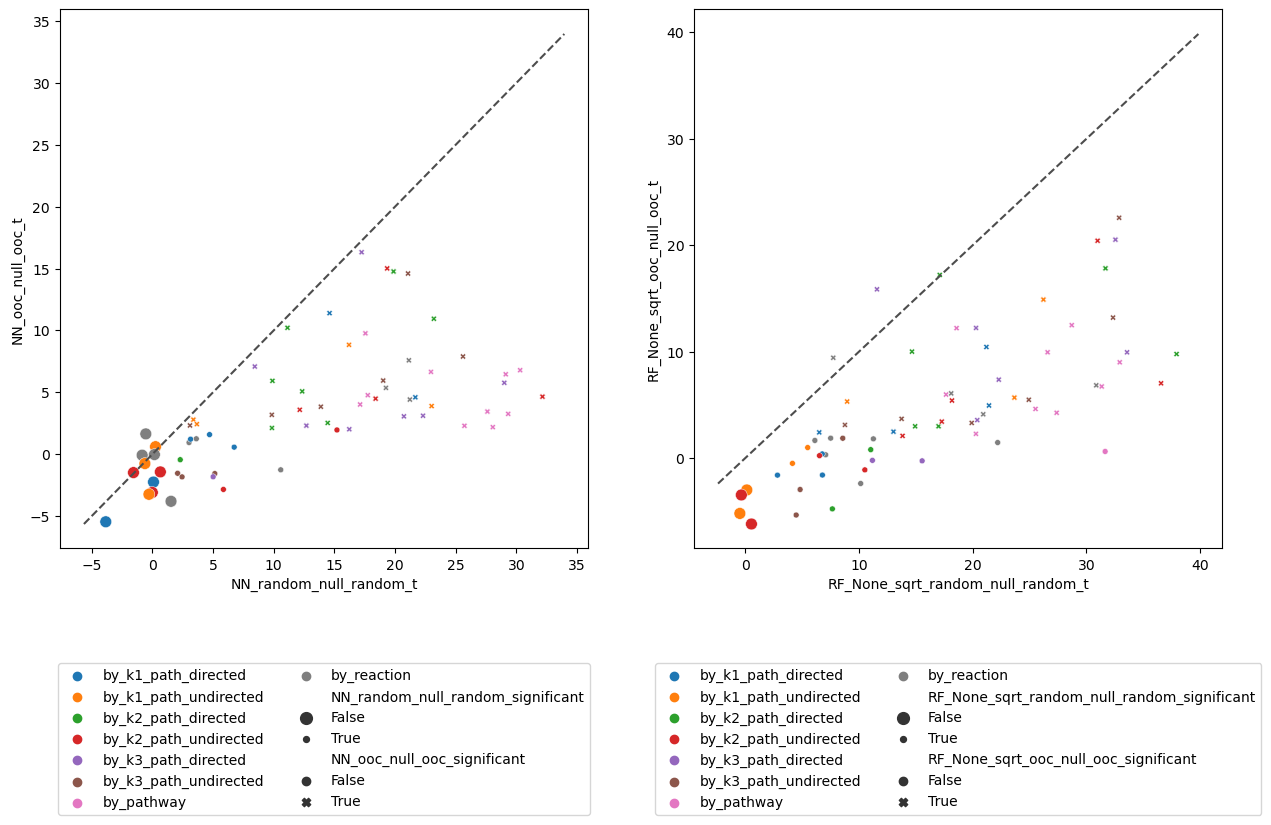

In [28]:
fig, axes=plt.subplots(figsize=(15,7), ncols=2, nrows=1)

sns.scatterplot(data=stats, x='NN_random_null_random_t', y='NN_ooc_null_ooc_t', hue='ko_selection_level', style='NN_ooc_null_ooc_significant',size="NN_random_null_random_significant",  ax=axes[0])
# legend to bottom, outside of plot
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
# draw line y=x
axes[0].plot(axes[0].get_xlim(), axes[0].get_xlim(), ls="--", c=".3")


sns.scatterplot(data=stats, x='RF_None_sqrt_random_null_random_t', y='RF_None_sqrt_ooc_null_ooc_t', hue='ko_selection_level', style='RF_None_sqrt_ooc_null_ooc_significant',size="RF_None_sqrt_random_null_random_significant",  ax=axes[1])
# legend to bottom, outside of plot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
# draw line y=x
axes[1].plot(axes[1].get_xlim(), axes[1].get_xlim(), ls="--", c=".3")


In [13]:
stats

stat,carbon_name,ko_selection_level,NN_ooc_null_ooc_p,NN_ooc_null_ooc_significant,NN_ooc_null_ooc_t,NN_random_null_random_p,NN_random_null_random_significant,NN_random_null_random_t,RF_None_sqrt_ooc_null_ooc_p,RF_None_sqrt_ooc_null_ooc_significant,RF_None_sqrt_ooc_null_ooc_t,RF_None_sqrt_random_null_random_p,RF_None_sqrt_random_null_random_significant,RF_None_sqrt_random_null_random_t
0,Arabinose,by_k1_path_directed,0.0,False,-5.458296,0.000167,False,-3.837728,0.113688,False,-1.590616,0.005009,True,2.841613
1,Arabinose,by_k1_path_undirected,0.543216,False,0.609329,0.794047,False,0.261412,0.62894,False,-0.484214,0.000048,True,4.157979
2,Arabinose,by_k2_path_directed,0.0,True,14.765976,0.0,True,19.878971,0.0,True,17.828427,0.0,True,31.674356
3,Arabinose,by_k2_path_undirected,0.0,True,15.013763,0.0,True,19.357888,0.0,True,20.426625,0.0,True,30.979105
4,Arabinose,by_k3_path_directed,0.0,True,16.318362,0.0,True,17.247724,0.0,True,20.526286,0.0,True,32.549351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Raffinose,by_k2_path_undirected,0.051486,False,1.960389,0.0,True,15.216005,0.037325,True,2.097668,0.0,True,13.837315
64,Raffinose,by_k3_path_directed,0.002203,True,3.106968,0.0,True,22.31016,0.00044,True,3.57969,0.0,True,20.399939
65,Raffinose,by_k3_path_undirected,0.000172,True,3.838664,0.0,True,13.888271,0.000291,True,3.699454,0.0,True,13.752615
66,Raffinose,by_pathway,0.022537,True,2.300007,0.0,True,25.724788,0.000007,True,4.627369,0.0,True,25.52445


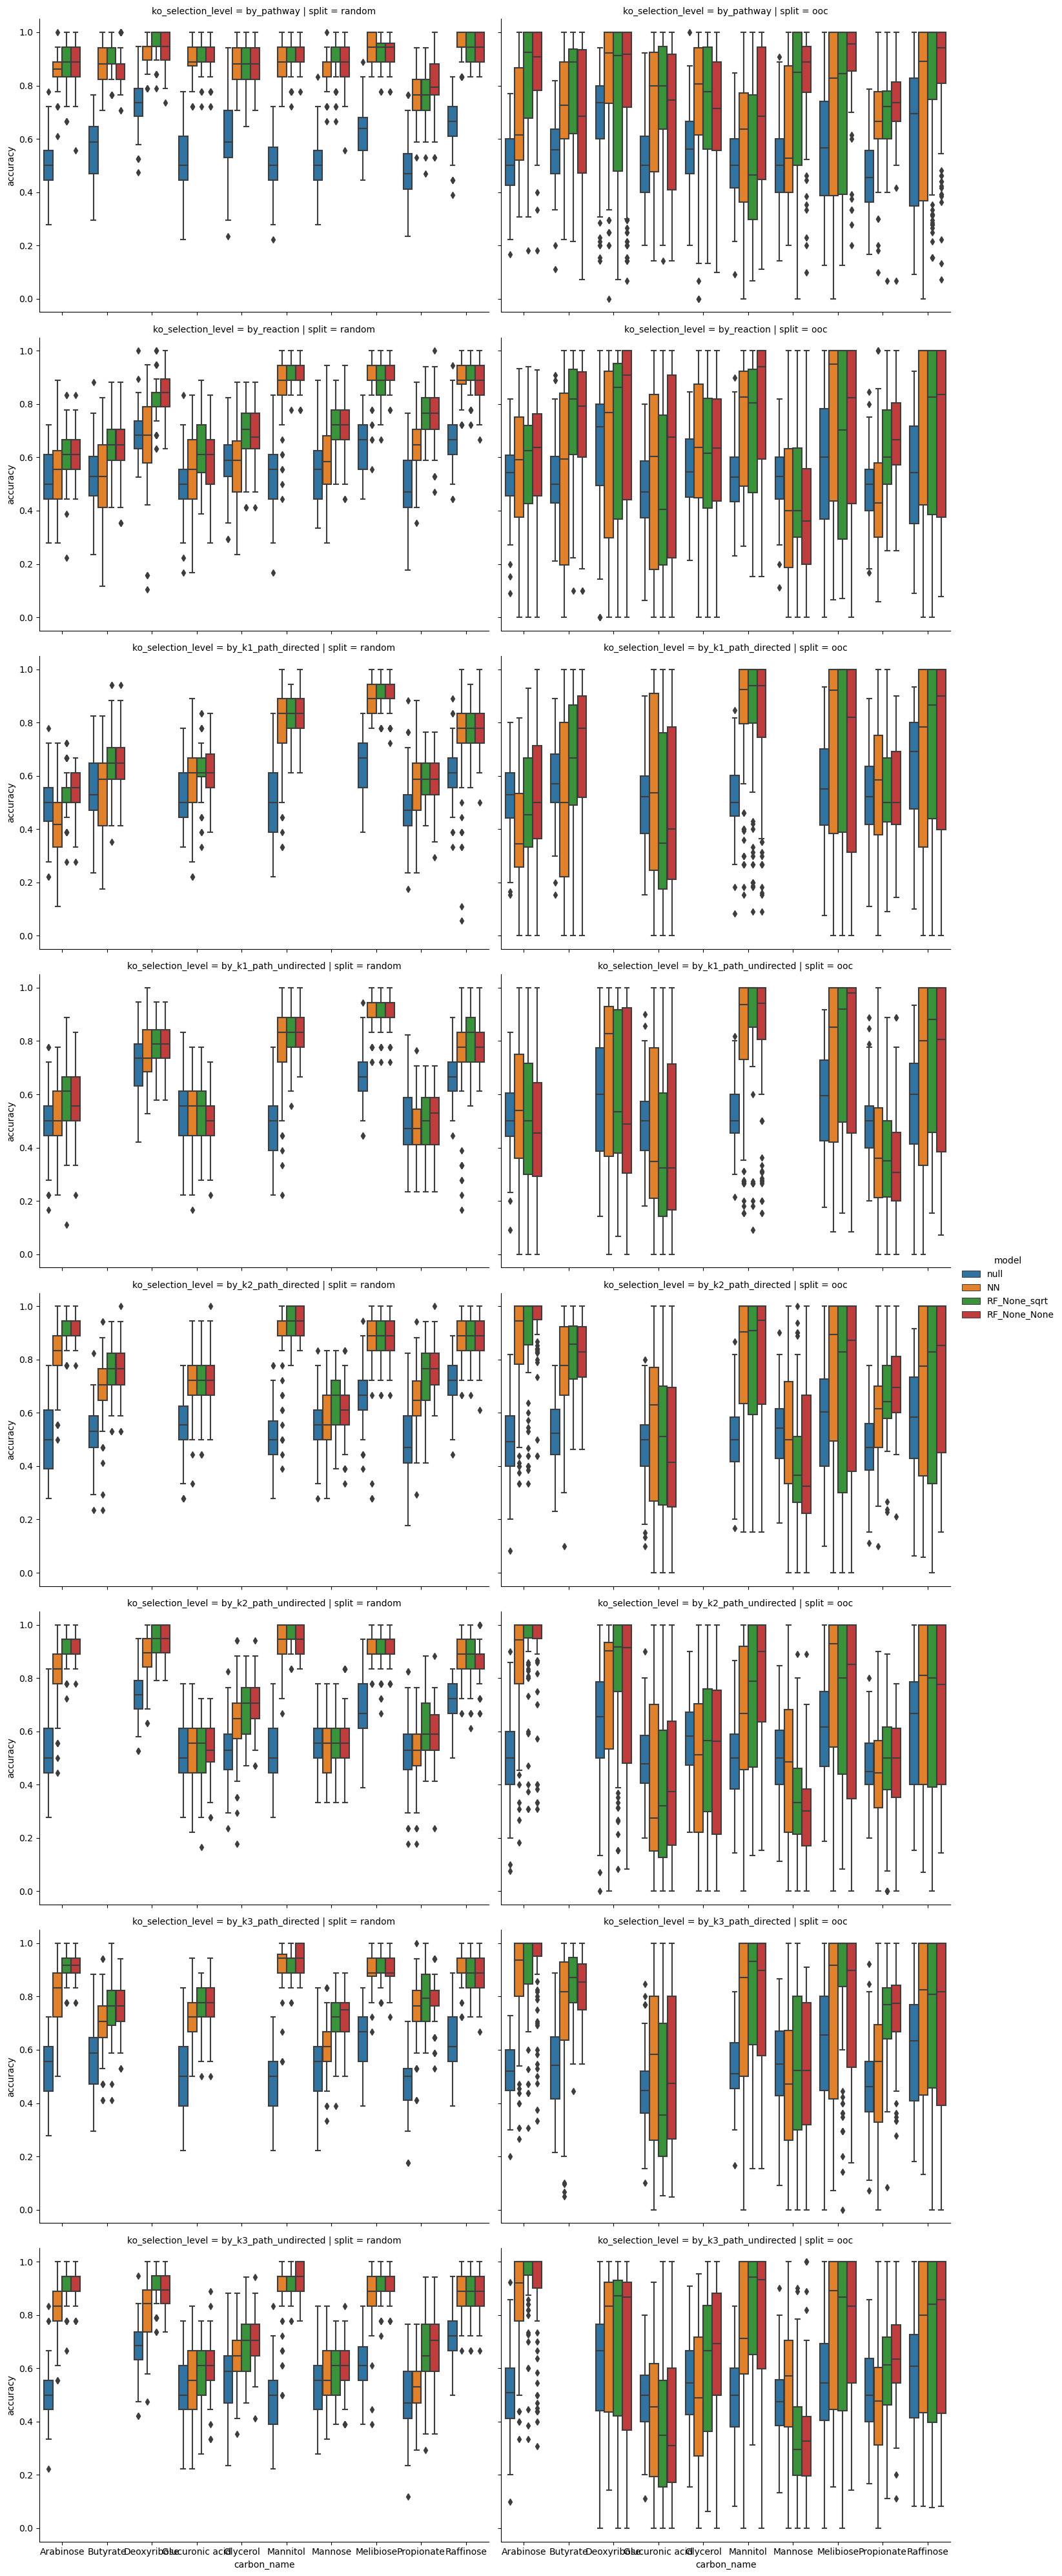

In [6]:
sns.catplot(data=results_all, x='carbon_name',y='accuracy',row='ko_selection_level',hue='model',kind='box',col='split',
            height=5, aspect=1.5, sharey=True)

In [45]:
df_mean=results_all.groupby(['carbon_name','split','model','ko_selection_level'])['accuracy'].mean().reset_index().rename(columns={'accuracy':'accuracy_mean'})
df_random,df_ooc=df_mean[df_mean['split']=='random'].drop(columns='split'),df_mean[df_mean['split']=='ooc'].drop(columns='split')
df_mean=pd.merge(df_random,df_ooc, on=['carbon_name','model','ko_selection_level'], suffixes=('_random','_ooc'))

df_std=results_all.groupby(['carbon_name','split','model','ko_selection_level'])['accuracy'].std().reset_index().rename(columns={'accuracy':'accuracy_std'})
df_random,df_ooc=df_std[df_std['split']=='random'].drop(columns='split'),df_std[df_std['split']=='ooc'].drop(columns='split')
df_std=pd.merge(df_random,df_ooc, on=['carbon_name','model','ko_selection_level'], suffixes=('_random','_ooc'))

df=pd.merge(df_mean,df_std, on=['carbon_name','model','ko_selection_level'])

In [46]:
df

,carbon_name,model,ko_selection_level,accuracy_mean_random,accuracy_mean_ooc,accuracy_std_random,accuracy_std_ooc
0,Arabinose,NN,by_k1_path_directed,0.423333,0.393947,0.124797,0.193562
1,Arabinose,NN,by_k1_path_undirected,0.510556,0.542772,0.119413,0.261004
2,Arabinose,NN,by_k2_path_directed,0.808333,0.846678,0.100929,0.197577
3,Arabinose,NN,by_k2_path_undirected,0.817222,0.857879,0.108066,0.188742
4,Arabinose,NN,by_k3_path_directed,0.803333,0.863907,0.116165,0.177748
...,...,...,...,...,...,...,...
267,Raffinose,null,by_k2_path_undirected,0.706667,0.621813,0.084708,0.223058
268,Raffinose,null,by_k3_path_directed,0.636667,0.596426,0.099387,0.216435
269,Raffinose,null,by_k3_path_undirected,0.711667,0.566864,0.091983,0.208192
270,Raffinose,null,by_pathway,0.666667,0.613203,0.096387,0.266764


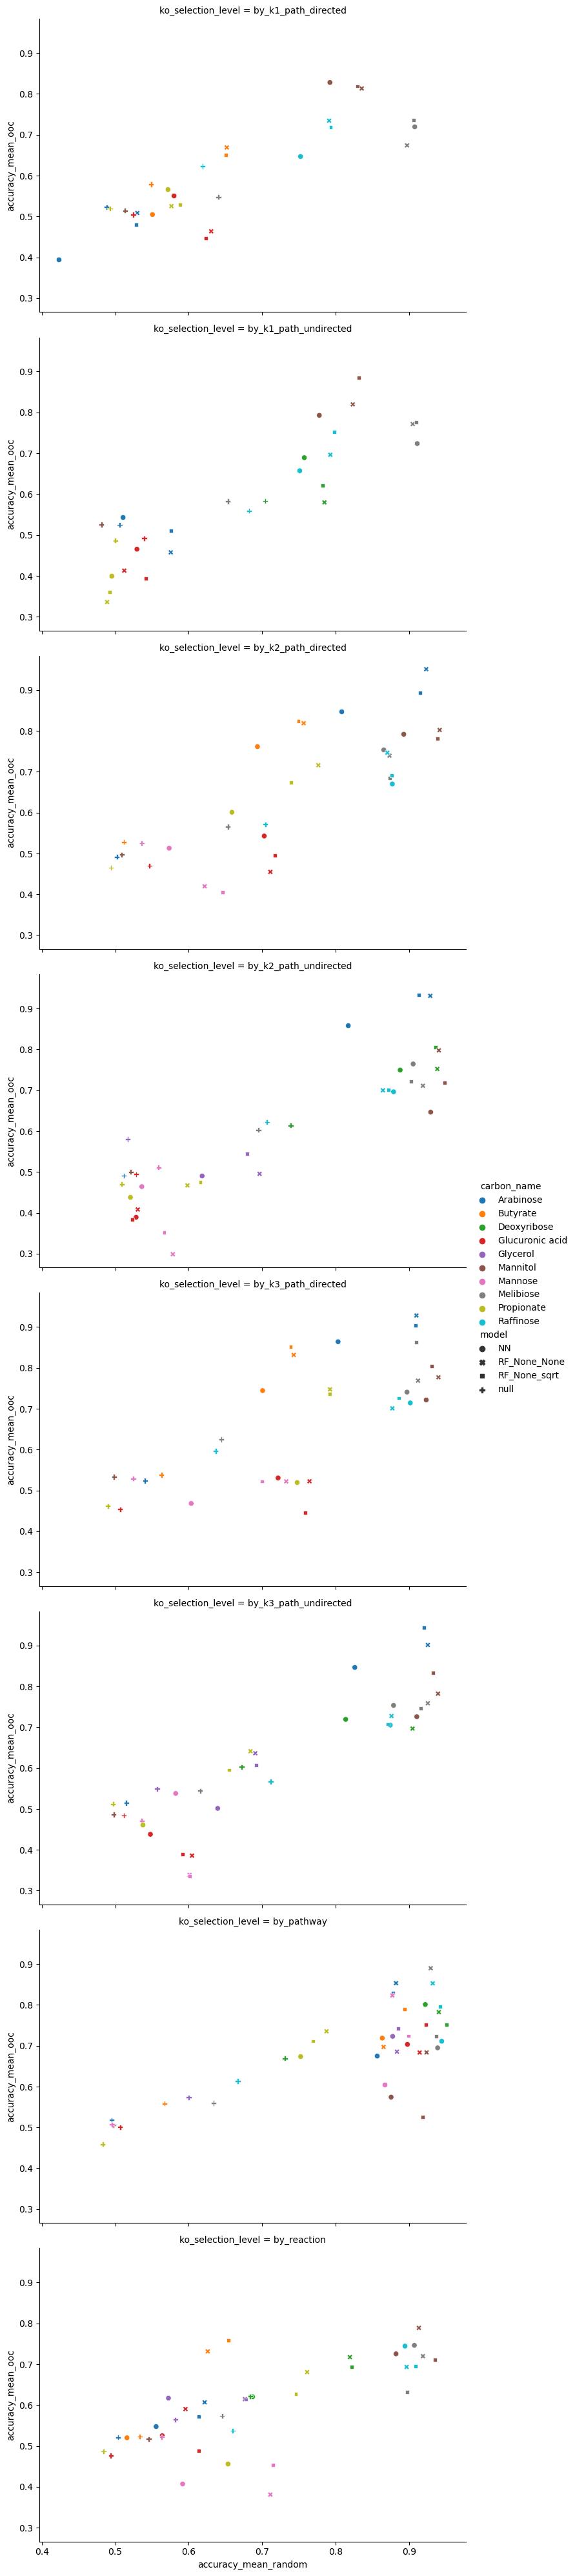

In [52]:
sns.relplot(data=df, x='accuracy_mean_random', y='accuracy_mean_ooc', hue='carbon_name', style='model',col='ko_selection_level', height=5, aspect=1.5,col_wrap=1)


In [ ]:
df

In [25]:
list(sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
for split_name, model_name, dataset_n